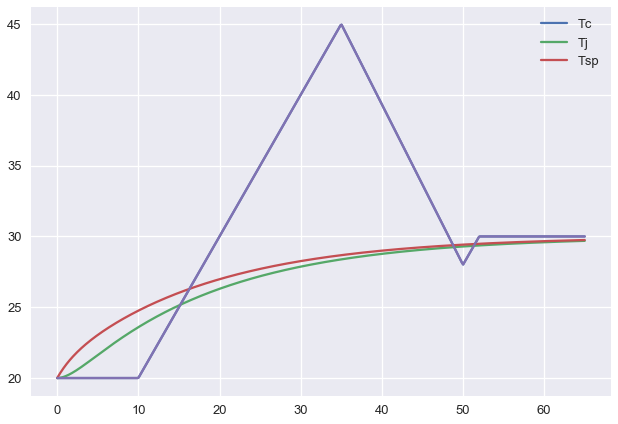

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import seaborn as sns
sns.set_context('talk')


tbreak = [0, 10, 35, 50, 52, 65]
Tbreak = [20,20,45,28,30,30]
Tsp = interp1d(tbreak,Tbreak,kind='linear')


t = np.linspace(0,65,500)
plt.plot(t,Tsp(t))

Tcf = 20
mw = 0.1
qs = 0.1

def deriv(X,t):
    Tc,Tj = X
    dTc = 0.3*(Tj-Tc)
    dTj = -0.3*(Tj-Tc) + mw*(Tcf - Tc) + qs*10.0
    return [dTc,dTj]

IC = [20,20]

X = odeint(deriv,IC,t)
Tc,Tj = X.transpose()

plt.plot(t,Tc,t,Tj,t,Tsp(t))
plt.legend(['Tc','Tj','Tsp'])

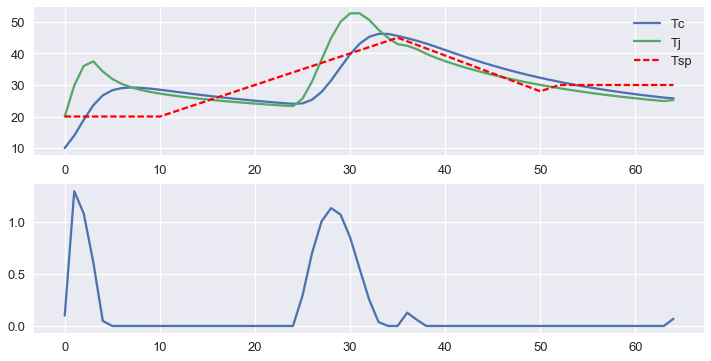

In [29]:
dt = 1

Tc = 10
Tj = 20
qs = 0.1

log = []
I = 0

for t in np.arange(0,65,dt):
    log.append([t,Tc,Tj,qs])
    I += (Tsp(t)-Tc)
    qs = 0.1*(Tsp(t)-Tc) + 0.03*I
    qs = max(0,qs)
    Tc,Tj = odeint(deriv,[Tc,Tj],[t,t+dt])[-1]


t,Tc,Tj,qs = np.asarray(log).T

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t,Tc,t,Tj,t,Tsp(t),'r--')
plt.legend(['Tc','Tj','Tsp'])

plt.subplot(2,1,2)
plt.plot(t,qs)
    